In [1]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [2]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import *
from pyspark.sql.types import *

MAX_MEMORY = '5G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = 'input_data.csv'
df = spark.read.option("delimiter", ";").option("header", "true").csv(filename_data, mode="DROPMALFORMED")
df = df.withColumn("price",df.price.cast(IntegerType())) \
    .withColumn("level",df.level.cast(IntegerType())) \
    .withColumn("levels",df.levels.cast(IntegerType())) \
    .withColumn("rooms",df.rooms.cast(IntegerType())) \
    .withColumn("area",df.area.cast(DoubleType())) \
    .withColumn("kitchen_area",df.kitchen_area.cast(DoubleType())) \
    .drop("date", "postal_code", "street_id", "house_id", "postal_code", "geo_lon", "geo_lat", "kitchen_area")

print('Data overview')
df.printSchema()

total_count = df.count()
total_count

Data overview
root
 |-- price: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- levels: integer (nullable = true)
 |-- rooms: integer (nullable = true)
 |-- area: double (nullable = true)
 |-- building_type: string (nullable = true)
 |-- object_type: string (nullable = true)
 |-- id_region: string (nullable = true)



11358150

### Вывод пропущенных значений

In [3]:
string_columns = ['id_region', 'object_type', 'building_type']
numeric_columns = ['kitchen_area','area', 'rooms', 'levels', 'level', 'price']

def view_missing_values_in_columns(string_columns, numeric_columns):
    missing_values = {}
    for index, column in enumerate(df.columns):
        if column in string_columns:
            missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        else: 
            missing_count = df.where(col(column).isin([0,None,np.nan]) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    
    return missing_values

pd.DataFrame.from_dict([view_missing_values_in_columns(string_columns, numeric_columns)])

,price,level,levels,rooms,area,building_type,object_type,id_region
0,8840,1467,2152,0,0,0,0,0


### Устранение пропущенных значений и вывод количества пропущенных значений после процедуры

In [4]:
df = df.withColumn('price', 
                   when(col('price').isin([0,None,np.nan]) | col('price').isNull(),
                        None).otherwise(col('price')))
df = df.dropna(subset=['price'])
df = df.withColumn('level', 
                   when(col('level').isin([0,None,np.nan]) | col('level').isNull(),
                        None).otherwise(col('level')))
df = df.dropna(subset=['level'])
df = df.withColumn('levels', 
                   when(col('levels').isin([0,None,np.nan]) | col('levels').isNull(),
                        None).otherwise(col('levels')))
df = df.dropna(subset=['levels'])
pd.DataFrame.from_dict([view_missing_values_in_columns(string_columns, numeric_columns)])

,price,level,levels,rooms,area,building_type,object_type,id_region
0,0,0,0,0,0,0,0,0


In [5]:
'Data frame describe (numeric columns only):'
df.select(df.price, df.level, df.levels, df.rooms, df.area).describe().toPandas()

'Data frame describe (numeric columns only):'

,summary,price,level,levels,rooms,area
0,count,11345931,11345931,11345931,11345931,11345931
1,mean,6410279.3551051915,6.4282132510765315,11.767053316294625,1.7193084463496209,53.10230816170283
2,stddev,1.5260297120412786E7,5.283499998898096,7.2182116173215105,1.157695778458437,27.125448171547085
3,min,1,1,1,-1,1.0
4,max,2147483647,50,50,9,499.9


### Используем межквартильный диапозон, чтобы устранить выбросы

In [6]:
for column in ['price', 'area']:

    # Q1 : First Quartile ., Q3 : Third Quartile
    Q1 = df.approxQuantile(column,[0.25],relativeError=0)
    Q3 = df.approxQuantile(column,[0.75],relativeError=0)
    # IQR : Inter Quantile Range
    # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
    # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
    IQR = Q3[0] - Q1[0]
        
    #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
    less_Q1 =  Q1[0] - 1.5*IQR
    more_Q3 =  Q3[0] + 1.5*IQR
           
    df = df.filter((df[column] < more_Q3) & (df[column] > less_Q1))  

df.select(df.price, df.rooms, df.area).describe().toPandas()
# df.toPandas().to_csv('mycsv.csv')

,summary,price,rooms,area
0,count,10059917,10059917,10059917
1,mean,4212274.851580187,1.5901397596023903,47.69744484953959
2,stddev,2411816.6781435004,1.0969306411476882,16.735495925719736
3,min,1,-1,1.0
4,max,12349999,9,96.3


### Вывод десяти регионов, в которых продают больше всего недвижимости

Top 10 regions:


/tmp/ipykernel_4289/46799644.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  xsticks_label = axs[0].set_xticklabels(highest_regions_df['id_region'],


,id_region,count,percentage
0,72,806002,7.096244
1,23,719704,6.336454
2,50,701405,6.175345
3,78,600426,5.286301
4,54,576183,5.072860
5,77,462629,4.073102
6,24,413255,3.638401
7,66,408386,3.595533
8,61,391769,3.449232
9,74,309614,2.725919


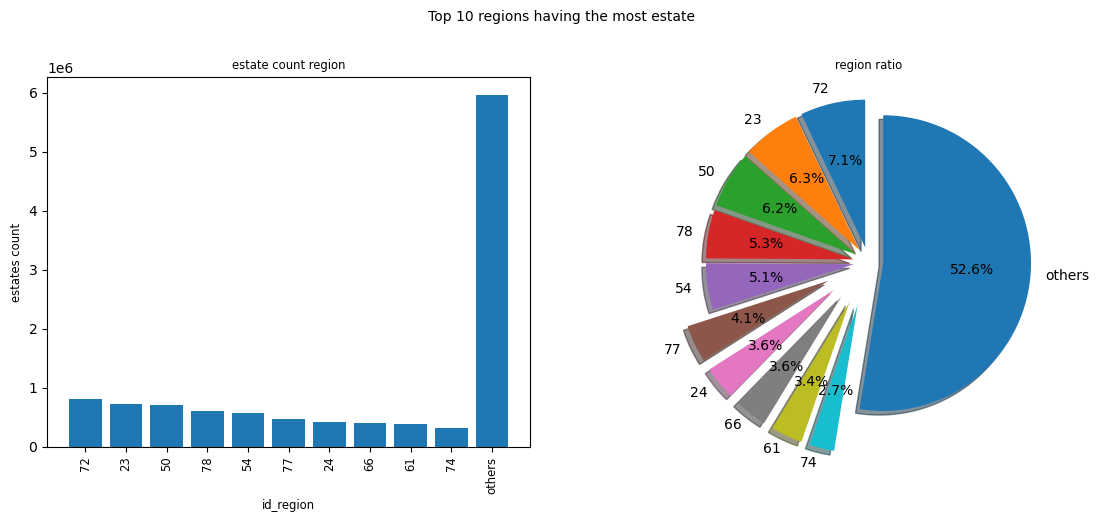

In [7]:
highest_regions_df = df.select(df.id_region, df.building_type) \
    .groupBy(df.id_region) \
    .count() \
    .orderBy("count", ascending=False) \
    .limit(10) \
    .toPandas()


highest_regions_df['percentage'] = highest_regions_df['count'] \
    / total_count * 100

others = {
    'id_region': 'others', 
    'count': total_count - np.sum(highest_regions_df['count']), 
    'percentage': 100 - np.sum(highest_regions_df['percentage'])
}

highest_regions_df = pd.concat([highest_regions_df,pd.DataFrame.from_dict([others])])


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.35))

plot0 =   axs[0].bar(x=highest_regions_df['id_region'], 
                     height=highest_regions_df['count'])
title0 =  axs[0].set_title('estate count region', fontsize = 'small')
xlabel0 = axs[0].set_xlabel('id_region', fontsize = 'small')
ylabel0 = axs[0].set_ylabel('estates count', fontsize = 'small')
xsticks_label = axs[0].set_xticklabels(highest_regions_df['id_region'],
                                       rotation = 'vertical', fontsize='small')
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.3,0.3,0.3,0.3,0.3,0.1)
title1 = axs[1].set_title('region ratio', fontsize = 'small')
plot1 = axs[1].pie(
    x=highest_regions_df['percentage'],
    labels=highest_regions_df['id_region'], 
    autopct='%1.1f%%', 
    shadow=True, 
    explode=explode, 
    startangle=90, 
    radius=1
)

print('Top 10 regions:')
highest_regions_df


text = fig.text(0.5, 1.02, 'Top 10 regions having the most estate', ha='center', va='top', transform=fig.transFigure)

### Распределение типов строений в регионах

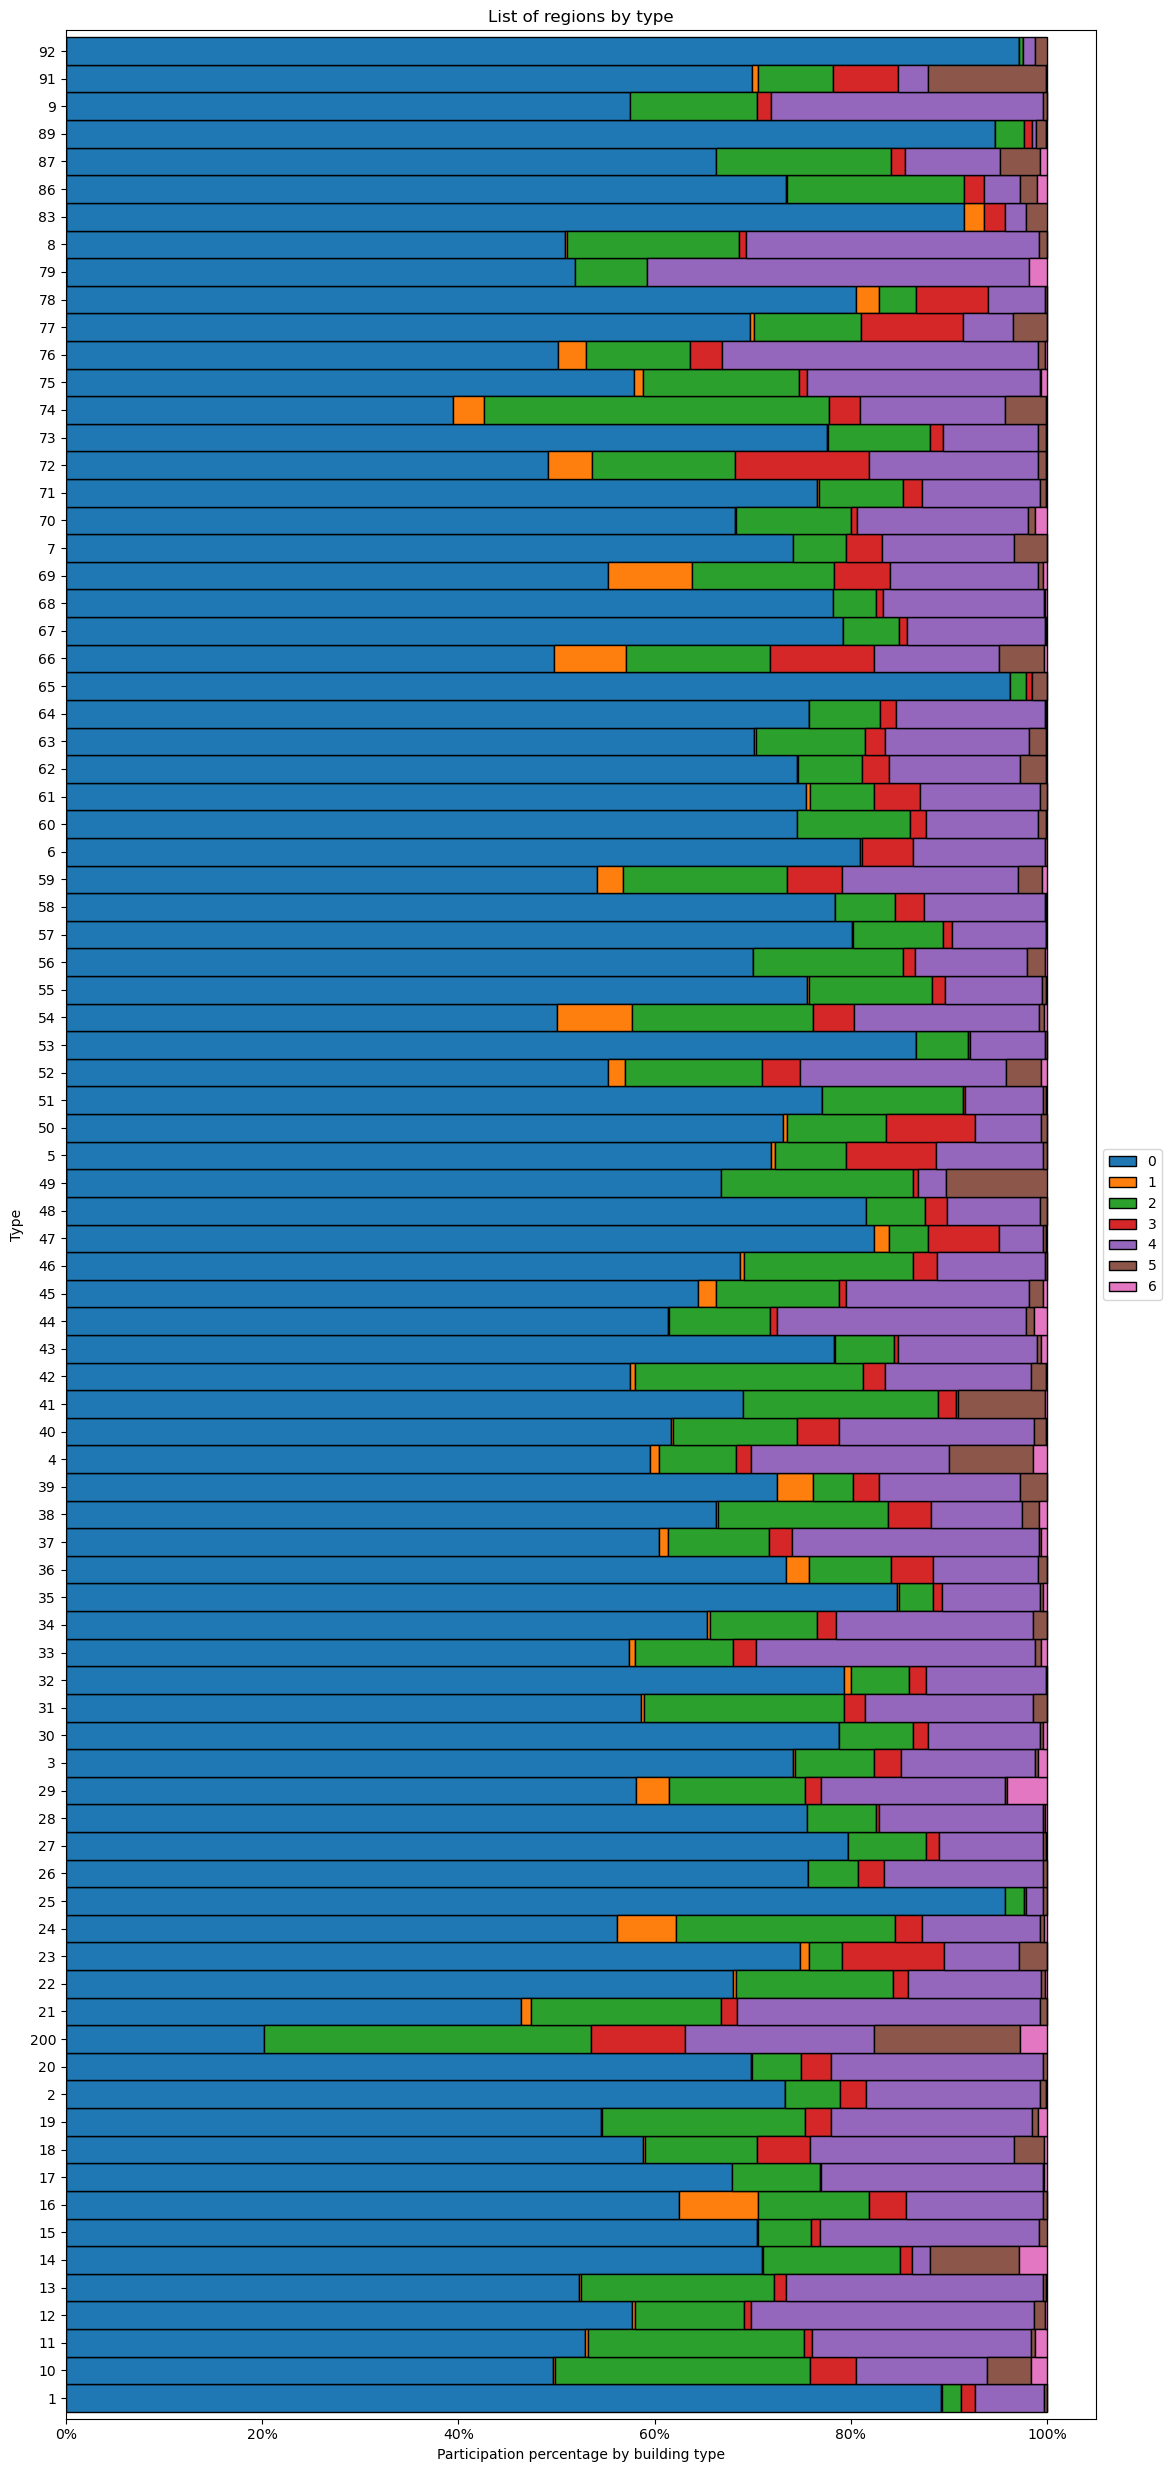

In [8]:
regions_by_estateType_df = df.groupBy(df.id_region, df.building_type).count().toPandas()

types = regions_by_estateType_df['building_type'].unique()

fig = plt.figure(figsize=(12, 25))
grid_size = (1,1);
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)
plot = regions_by_estateType_df.groupby(['id_region', 'building_type'],group_keys=True).agg(np.mean) \
    .groupby(level=0,group_keys=False) \
    .apply(
        lambda x: 100 * x / x.sum()).unstack().plot(kind='barh', 
                                                    stacked=True, 
                                                    width=1,
                                                    edgecolor='black', 
                                                    ax=ax, 
                                                    title='List of regions by type')
ylabel = plt.ylabel('Type');
xlabel = plt.xlabel('Participation percentage by building type');
legend = plt.legend(
    sorted(types), loc='center left', bbox_to_anchor=(1.0, 0.5)
)
param_update = plt.rcParams.update({'font.size': 16});
ax = plt.gca()
formatter = ax.xaxis.set_major_formatter(mtick.PercentFormatter());
a = fig.tight_layout()
plt.show()

### Средние цены на квартиры с различным кол-вом комнат

<AxesSubplot: xlabel='rooms'>

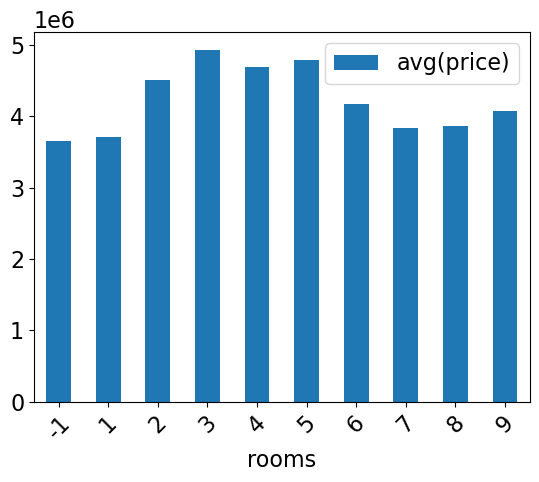

In [9]:
room_count = [-1,1,2,3,4,5,6,7,8,9]

df.select(df.rooms, df.price) \
    .filter(df.rooms.isin(room_count)) \
    .groupBy(df.rooms) \
    .avg('price') \
    .toPandas() \
    .sort_values(by='rooms') \
    .plot.bar(column="avg(price)", x='rooms', rot=45)

### Средняя цена на недвижимость в каждом регионе

<AxesSubplot: ylabel='id_region'>

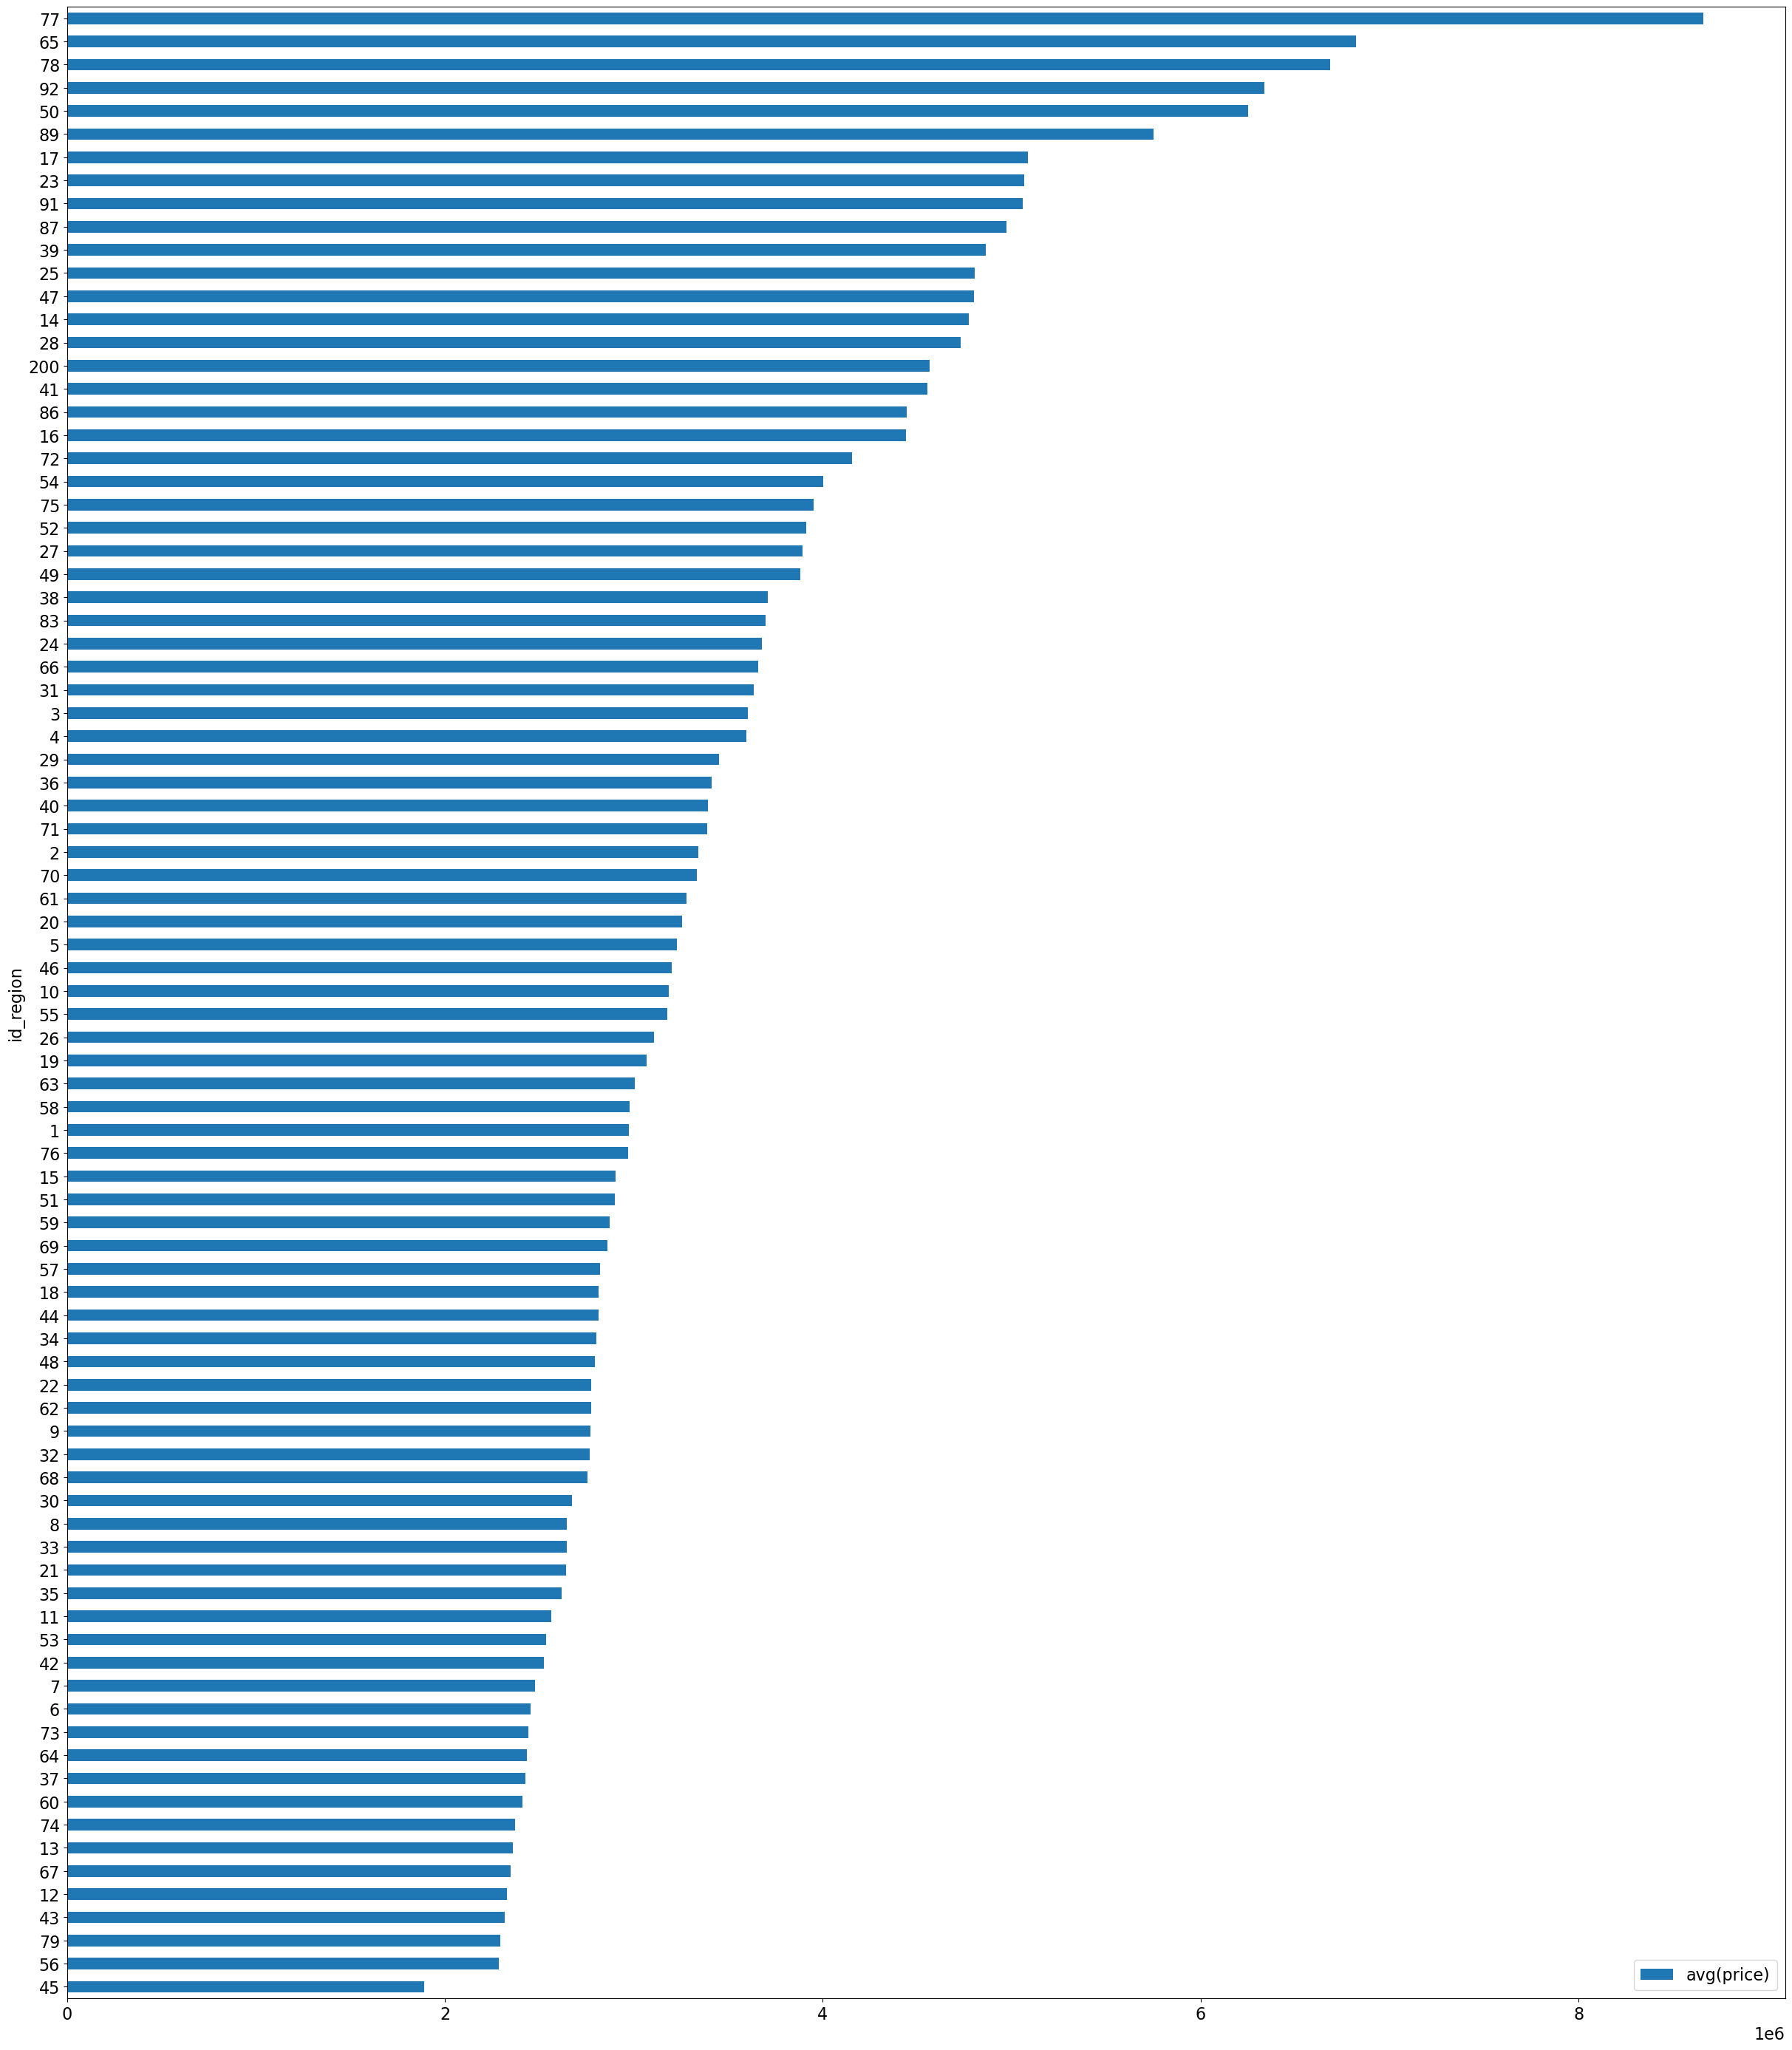

In [10]:
df.select(df.id_region, df.price) \
    .groupBy(df.id_region) \
    .avg('price') \
    .toPandas() \
    .sort_values(by='avg(price)') \
    .plot.barh(column="avg(price)", x='id_region', figsize=(30,35))

### Топ 5 самой продаваемой недвижимости (в зависимости от кол-ва комнат) в Москве, Волгограде, Краснодаре, Ростове и Саратове

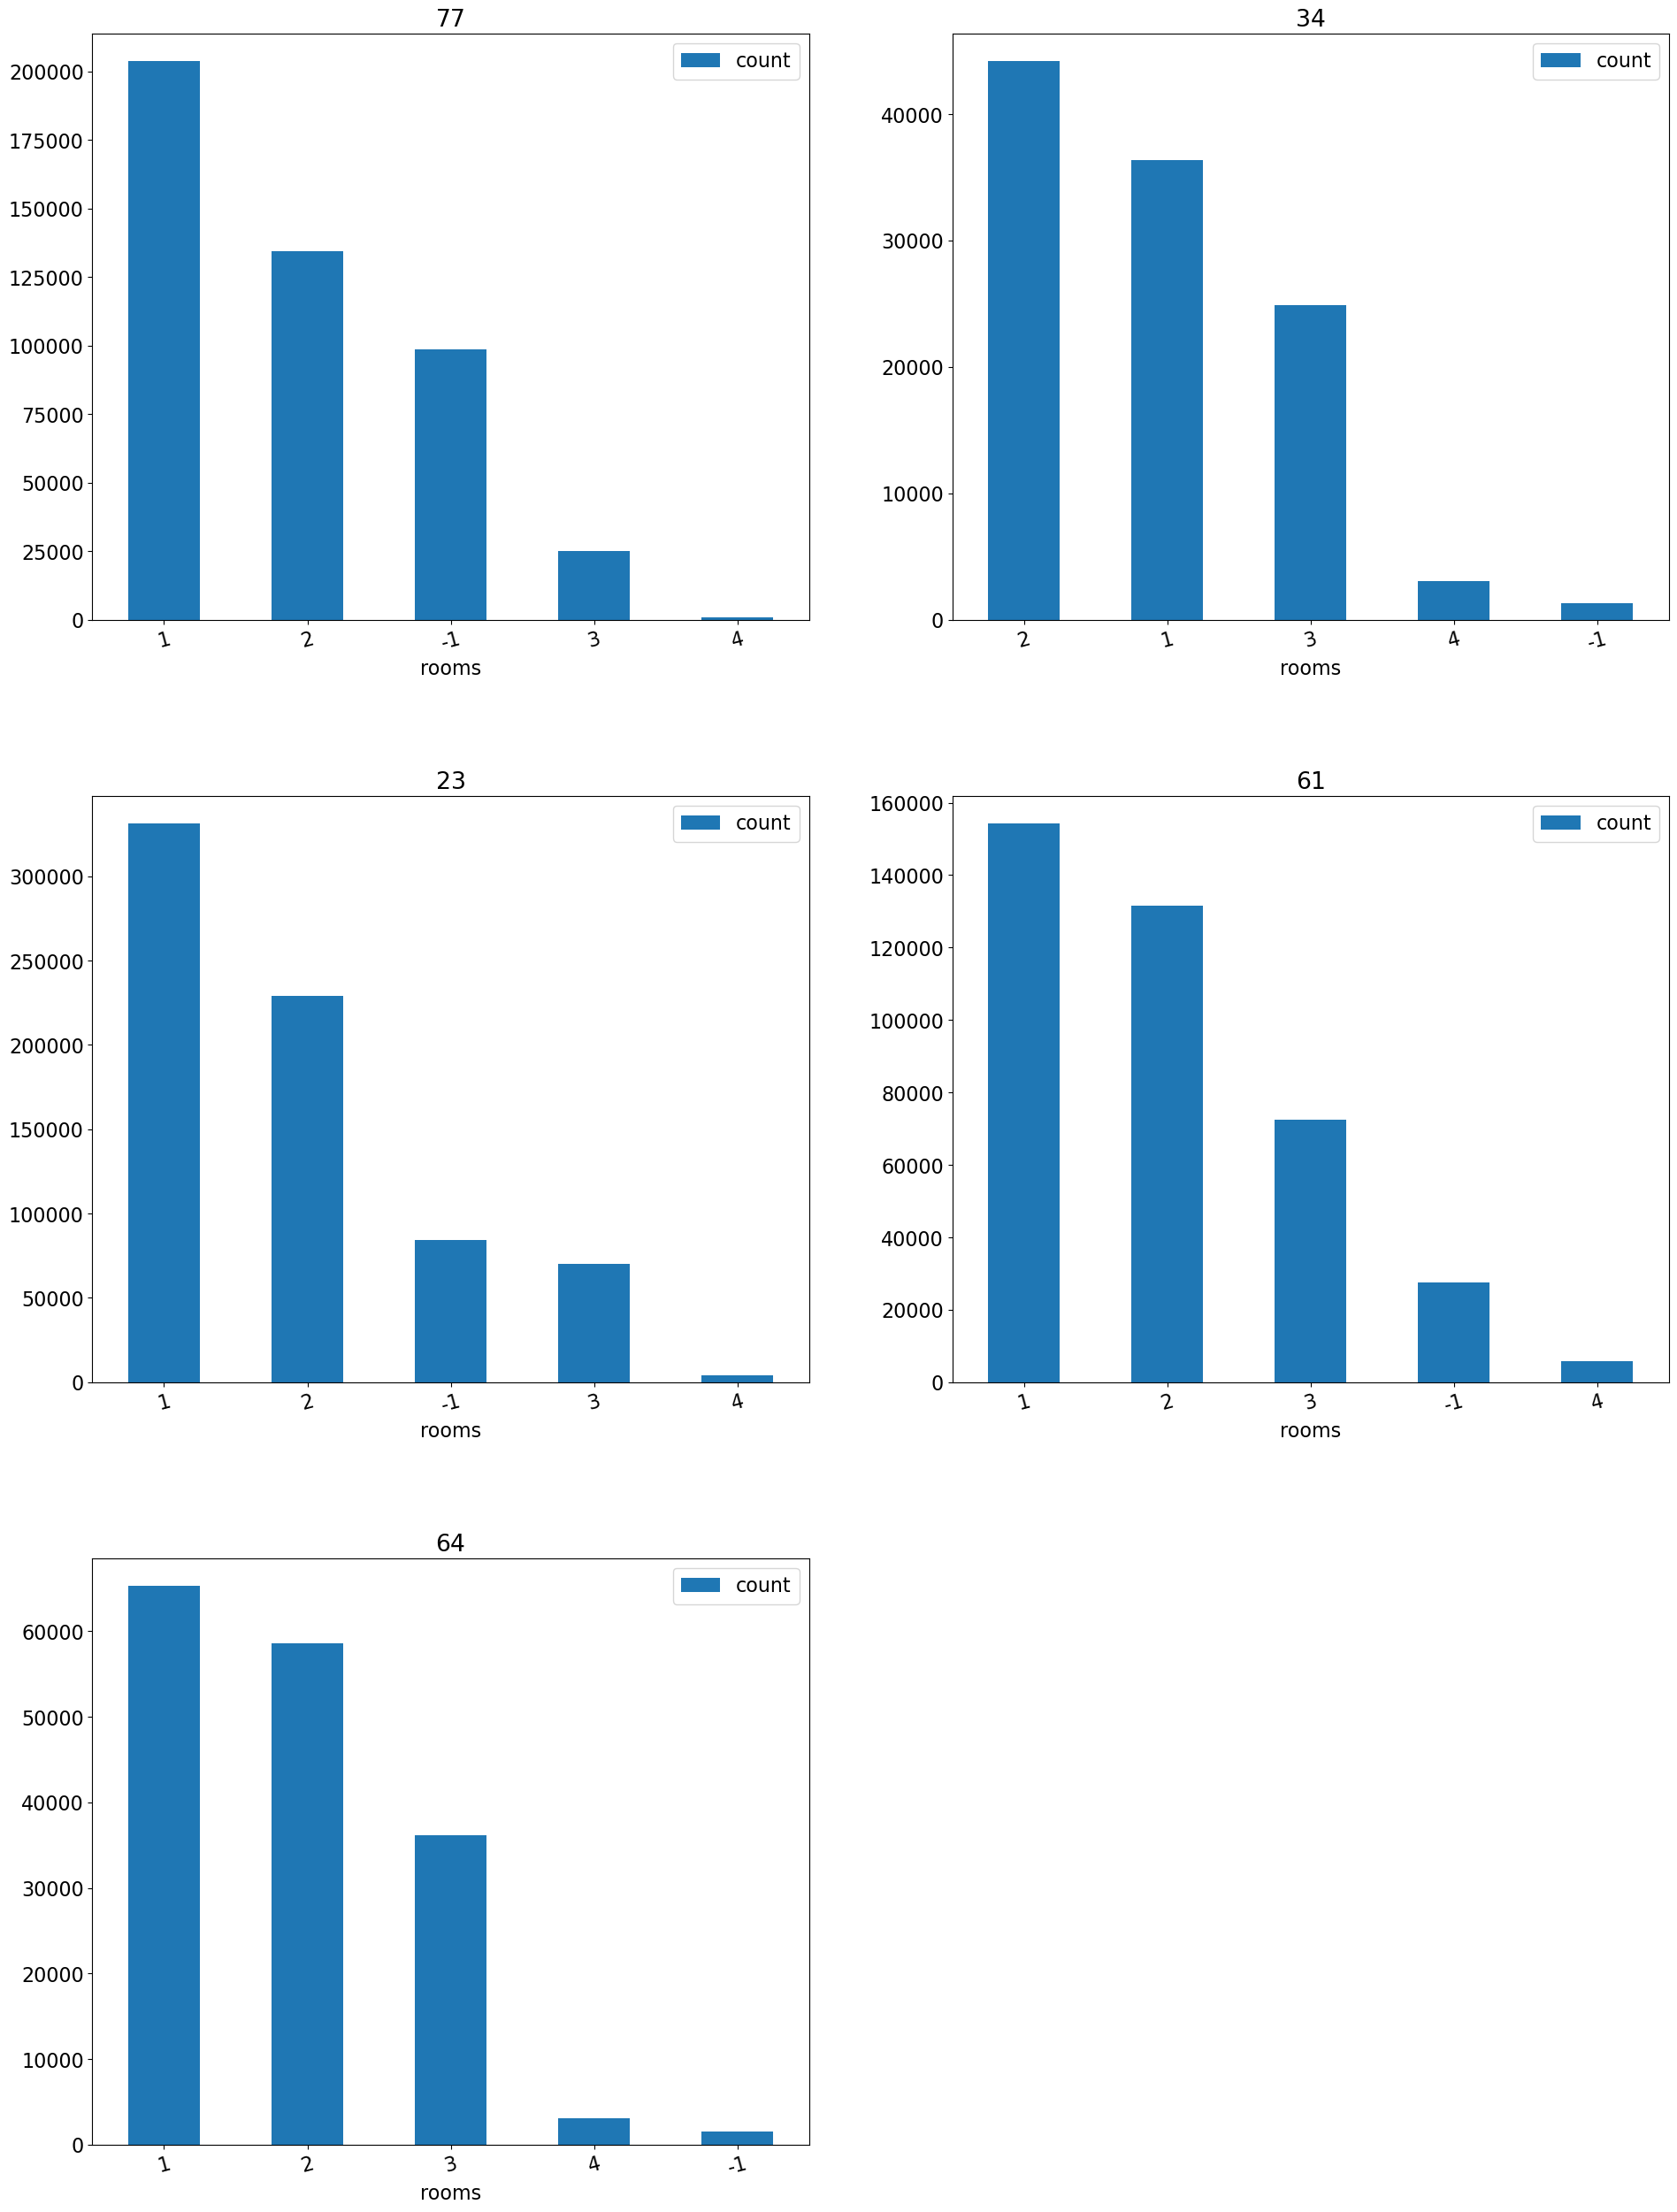

In [11]:
plot_size_x, plot_size_y = 10, 10
figsize_x, figsize_y = plot_size_x * 2 + 3, plot_size_y * 3 + 1
figsize=(figsize_x, figsize_y)
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(figsize_x, figsize_y))
regions = [77,34,23,61,64]

for i in range(len(regions)):
    row_index, col_index = divmod(i, 2)
    top_sold_by_region = df.select(df.rooms, df.id_region) \
        .filter(df.id_region == regions[i]) \
        .groupBy('rooms') \
        .count() \
        .toPandas() \
        .sort_values(by='count', ascending=False) \
        .head(5)
    _ = top_sold_by_region.plot.bar(column="count", x='rooms', rot=15, ax = ax[row_index, col_index])
    _ = ax[row_index, col_index].set_title(regions[i])

ax[2, 1].set_visible(False)
plt.subplots_adjust(hspace=0.3)

### Средняя площадь апартементов в 10 регионах

In [12]:
area_mean = [] 
area_stddev = []
area_min = [] 
area_max = []

for id_region in highest_regions_df['id_region']:
    if id_region != 'others': 
        describe_values = df.select(df.area).filter(df.id_region == id_region).describe().toPandas()
    else:
        regions = highest_regions_df['id_region'].tolist()
        describe_values = df.select(df.area).filter(col('id_region').isin(regions) == False).describe().toPandas()
    area_mean.append(float(describe_values.loc[1]['area']))
    area_stddev.append(float(describe_values.loc[2]['area']))
    area_min.append(float(describe_values.loc[3]['area']))
    area_max.append(float(describe_values.loc[4]['area']))

highest_regions_df['mean area'] = area_mean
highest_regions_df['stddev area'] = area_stddev
highest_regions_df['min area'] = area_min
highest_regions_df['max area'] = area_max
    
highest_regions_df

,id_region,count,percentage,mean area,stddev area,min area,max area
0,72,806002,7.096244,49.384037,18.623114,1.0,96.3
1,23,719704,6.336454,46.209074,16.553424,1.0,96.3
2,50,701405,6.175345,46.988247,15.803963,2.7,96.3
3,78,600426,5.286301,42.029509,15.638191,1.5,96.3
4,54,576183,5.072860,47.486278,16.792302,1.0,96.3
5,77,462629,4.073102,38.560803,13.756068,4.0,96.3
6,24,413255,3.638401,49.182448,17.720087,1.0,96.3
7,66,408386,3.595533,48.095667,17.316555,2.0,96.3
8,61,391769,3.449232,48.501676,16.405836,1.0,96.3
9,74,309614,2.725919,50.006166,16.334286,3.0,96.3


#### Диаграмма "ящик с усами" по всем регионам и площади

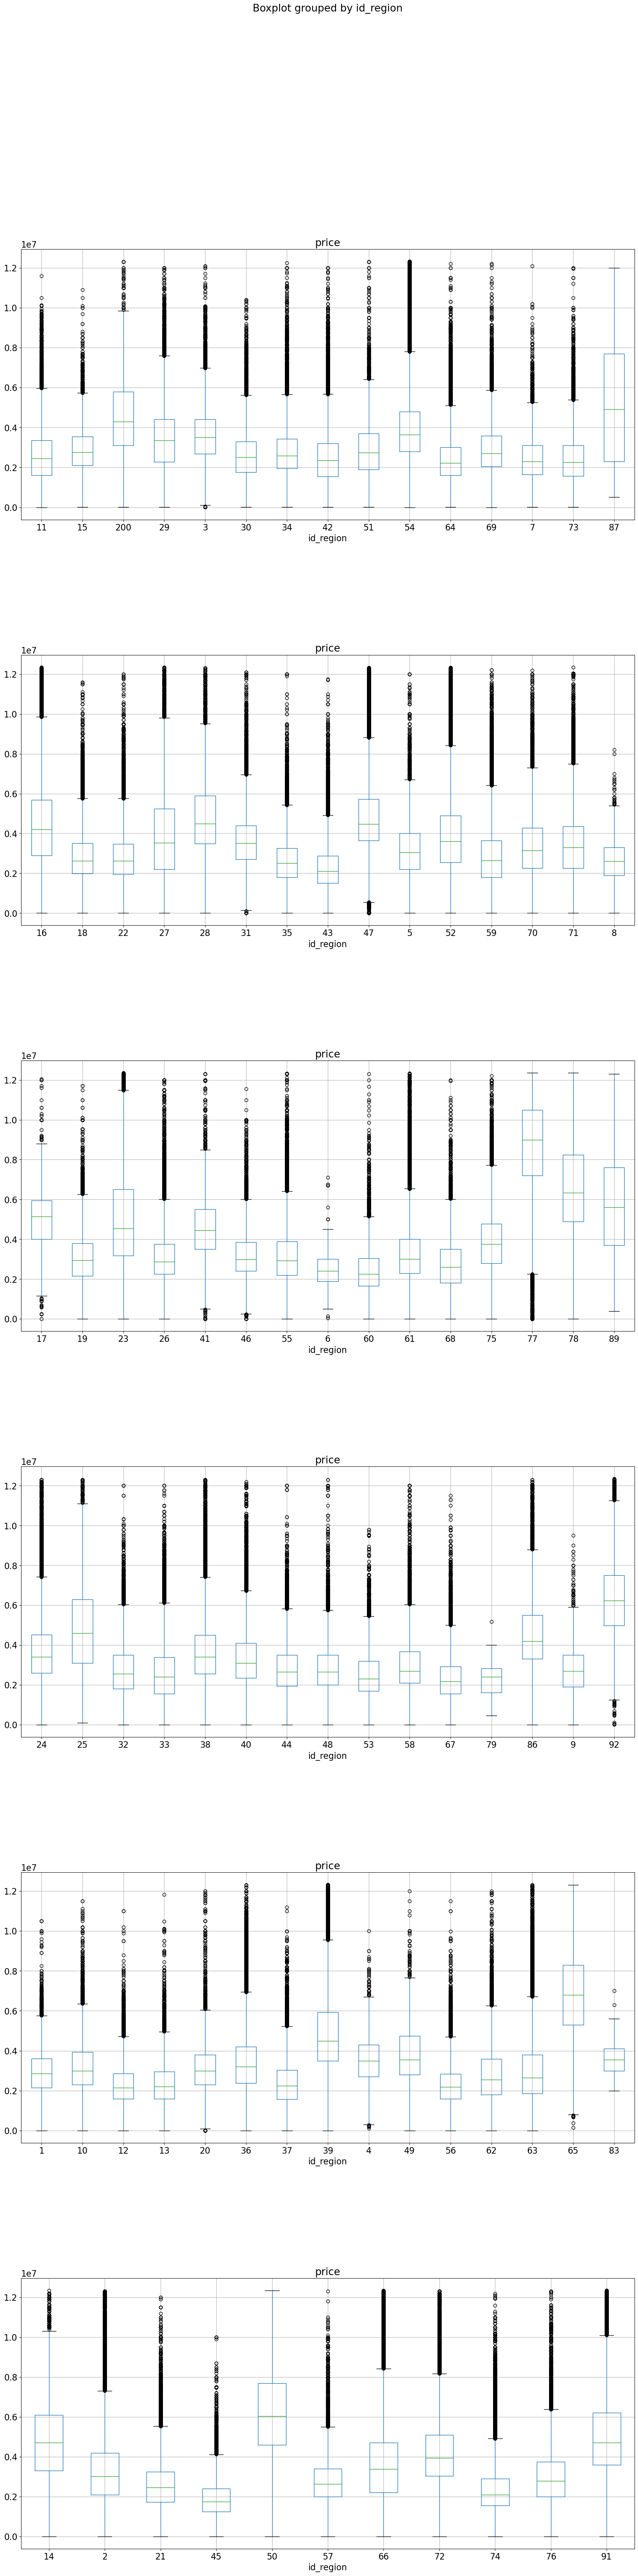

In [13]:
all_regions = df.select(df.id_region).distinct().toPandas()
boxplot_cols = 15
boxplot_rows = math.ceil(all_regions.count()/boxplot_cols)

fig, axes = plt.subplots(boxplot_rows, figsize=(20, 80))

for row in range(0,boxplot_rows):
    current_regs = all_regions.iloc[row*boxplot_cols:row*boxplot_cols+boxplot_cols]['id_region'].values.tolist()
    price_df = df.select(df.id_region, df.price).filter(col('id_region').isin(current_regs)).toPandas()
    price_df.boxplot(column='price', by='id_region', ax=axes[row])
    
plt.subplots_adjust(hspace=0.5)
plt.show();

### Статистика по ценам для каждого региона

In [14]:
regions_prices_statistic_df = []
all_regions = df.select(df.id_region) \
    .distinct() \
    .rdd.flatMap(lambda x: x).collect()

for id_region in all_regions:
    stat_dict = {'id_region': id_region}
    region_prices_df = df.select(df.price).filter(df.id_region==id_region)
    stats = region_prices_df.select(
        percentile_approx(df.price,[0.25,0.5,0.75,0.95], 1000000).alias("percentiles"),
        min('price').alias('min'),
        max('price').alias('max'),
        mean('price').alias('mean'),
        stddev('price').alias('stddev'),
    ).collect()[0]
    stat_dict['25th percentile'] = stats['percentiles'][0] 
    stat_dict['50th percentile'] = stats['percentiles'][1]
    stat_dict['75th percentile'] = stats['percentiles'][2]
    stat_dict['95th percentile'] = stats['percentiles'][3]
    
    stat_dict['min'] = stats['min']
    stat_dict['max'] = stats['max']
    stat_dict['mean'] = stats['mean']
    stat_dict['stddev'] = stats['stddev']
    
    regions_prices_statistic_df.append(stat_dict)
    
regions_prices_statistic_df = pd.DataFrame(regions_prices_statistic_df)
regions_prices_statistic_df

,id_region,25th percentile,50th percentile,75th percentile,95th percentile,min,max,mean,stddev
0,7,1645000,2300003,3100002,4600000,730,12100000,2.477425e+06,1.152766e+06
1,51,1900000,2740000,3700000,5500000,550,12300000,2.897497e+06,1.456763e+06
2,54,2799000,3650000,4800000,7500000,1,12327000,4.002530e+06,1.784659e+06
3,15,2100000,2750000,3550000,5000000,1900,10900000,2.902563e+06,1.127909e+06
4,200,3100000,4300000,5800000,8500000,1600,12300000,4.566543e+06,2.096120e+06
...,...,...,...,...,...,...,...,...,...
81,76,2000000,2778800,3753585,5480000,2350,12300000,2.971354e+06,1.400334e+06
82,2,2090000,3020000,4180000,6800000,320,12318094,3.340062e+06,1.767814e+06
83,50,4600000,6038612,7700000,10507280,1150,12348765,6.249306e+06,2.324606e+06
84,57,1995000,2623050,3400000,5211470,300,12300000,2.820409e+06,1.300452e+06


### Гистограммы (для статистики квантилей) и линейные диаграммы (для мин/макс/среднее/стандартное отклонение).

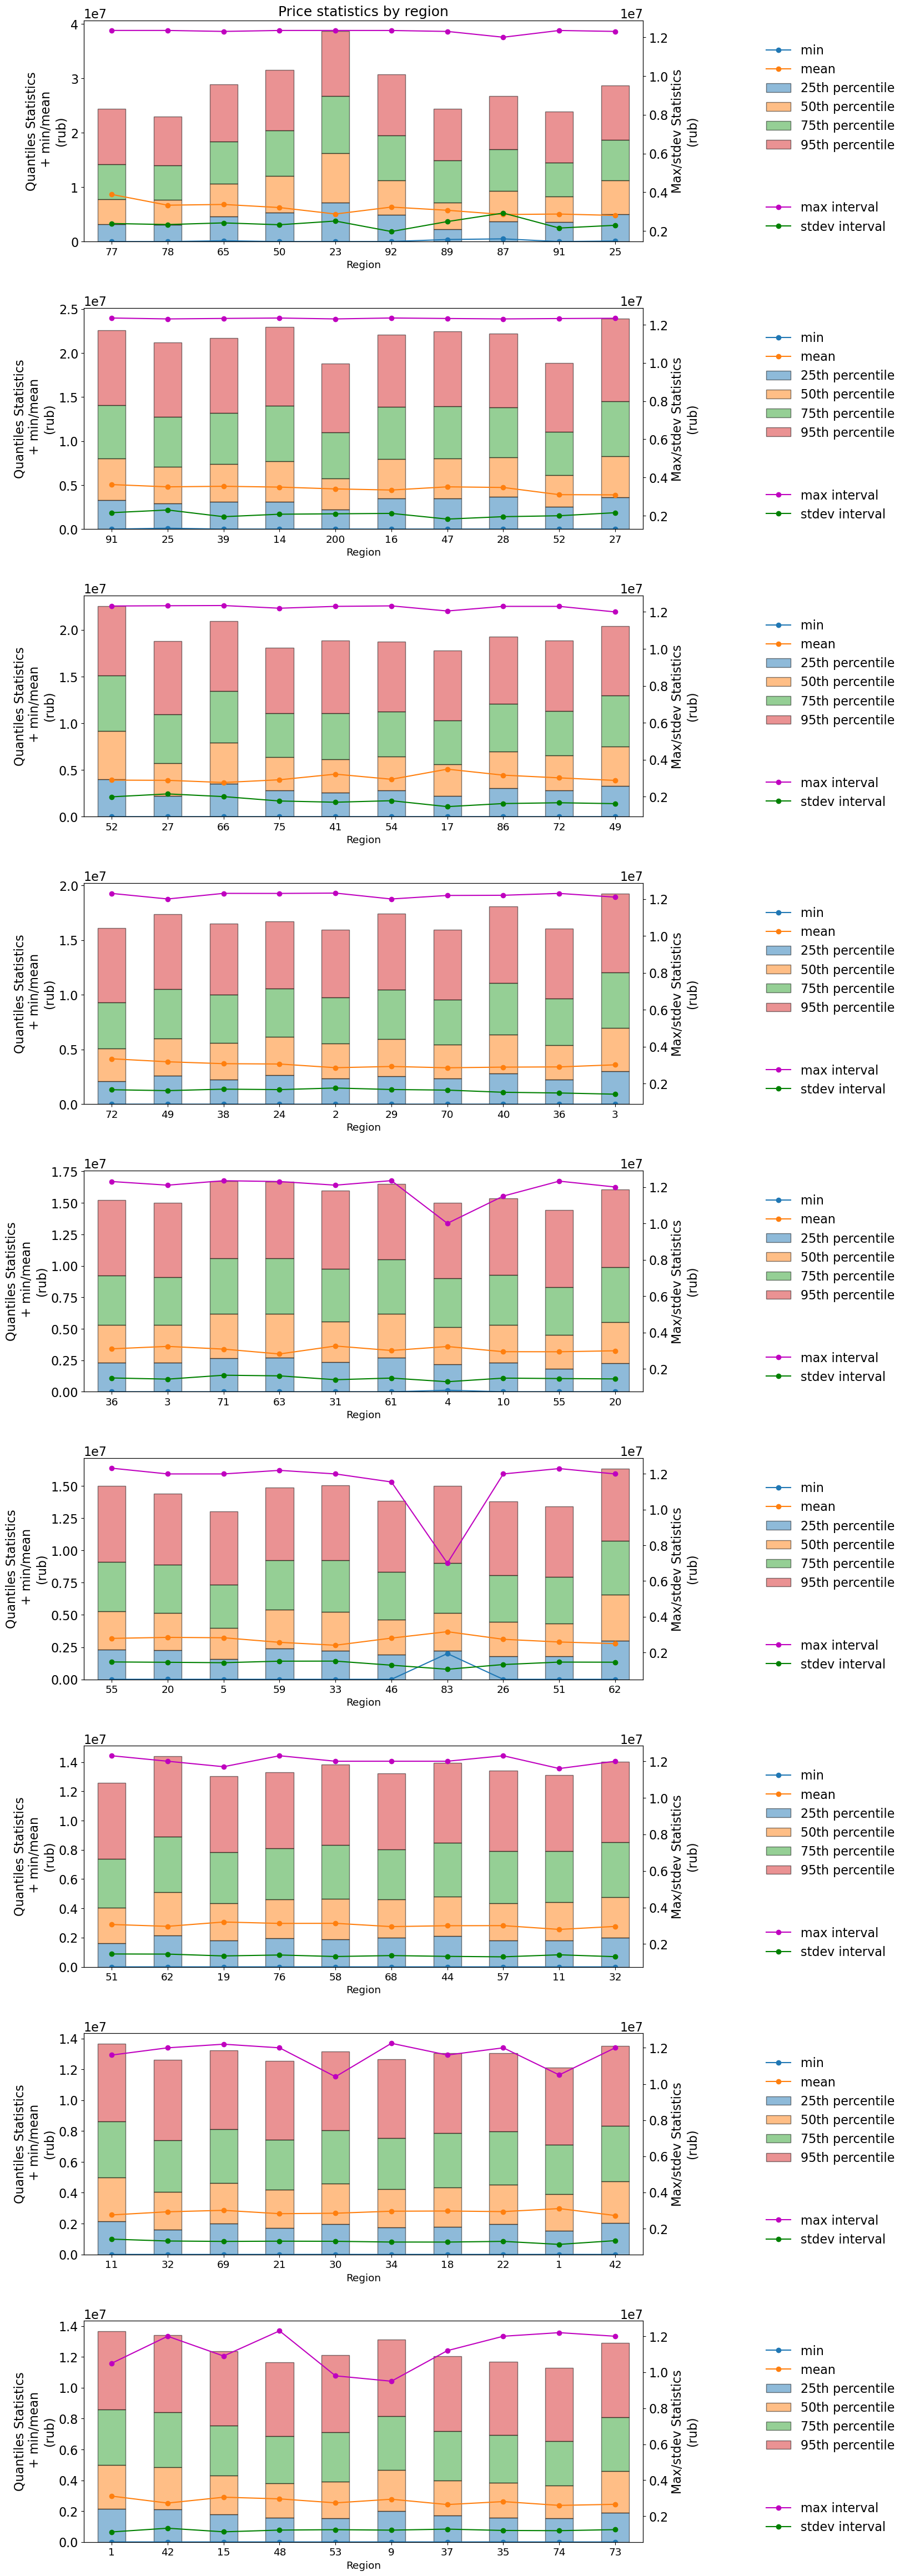

In [15]:
bar_columns = ['25th percentile', '50th percentile'
               , '75th percentile', '95th percentile']
line_columns1 = ['min', 'mean'] 
line_columns2 = ['max', 'stddev'] 
regions_prices_statistic_df = regions_prices_statistic_df.sort_values(
    by='95th percentile', ascending=False
)
figsize=(13, 59)
nrows = math.ceil(len(all_regions)/10)
fig, axs = plt.subplots(nrows=nrows, figsize=figsize)

d = axs[0].set_title('Price statistics by region', fontsize=18)
for i in range (nrows):
    regions_prices_statistic_sub_df = regions_prices_statistic_df.iloc[i*8:i*8+10,]
    plot1 = regions_prices_statistic_sub_df[['id_region'] + bar_columns] \
        .groupby(['id_region']).agg(np.mean).plot(
        kind='bar', stacked=True, grid=False, alpha=0.5, edgecolor='black', ax=axs[i], 
    )
    plot2 = regions_prices_statistic_sub_df[['id_region'] + line_columns1].plot(x='id_region', ax=axs[i], marker='o')
    ax2 = axs[i].twinx()
    plot3 = regions_prices_statistic_sub_df[['id_region'] + line_columns2].plot( x='id_region', ax=ax2, marker='o', color=['m', 'g'])
    a = axs[i].legend(loc='center left', fontsize=16, bbox_to_anchor=(1.2, 0.65), frameon=False)
    a = ax2.legend(  labels=['max interval', 'stdev interval']
                   , loc="center left", fontsize=16, bbox_to_anchor=(1.2, 0.11), frameon=False)
    b = axs[i].set_xticklabels(regions_prices_statistic_sub_df['id_region'],rotation = 'horizontal', fontsize='small')
    c = axs[i].set_xlabel('Region', fontsize='small');
    d = axs[i].set_ylabel('Quantiles Statistics\n + min/mean\n(rub)', fontsize=16);
    e = ax2.set_ylabel('Max/stdev Statistics\n(rub)', fontsize=16)
    ax2.tick_params(axis='y', labelsize=16)
    b = plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=True)

plt.subplots_adjust(hspace=0.3)
plt.show();

### Соотношения недвижимости по типу строения

<AxesSubplot: ylabel='процент'>

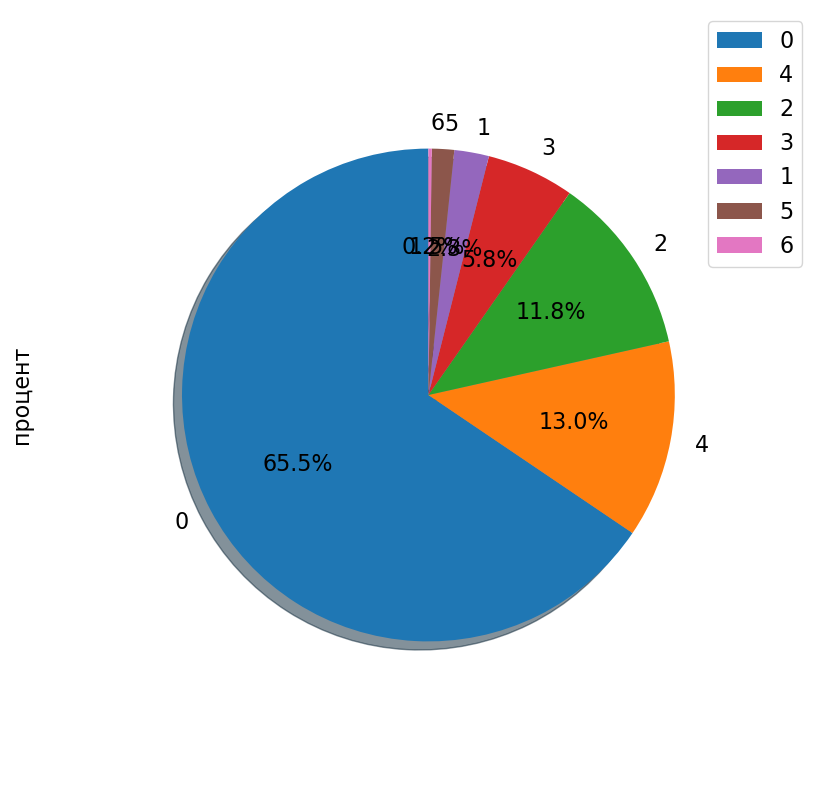

In [16]:
highest_build_types_df = df.select(df.building_type) \
    .groupBy(df.building_type) \
    .count() \
    .orderBy("count", ascending=False) \
    .toPandas()

highest_build_types_df['процент'] = highest_build_types_df['count'] \
    / total_count * 100


highest_build_types_df.plot.pie(
    y='процент',
    labels=highest_build_types_df['building_type'], 
    autopct='%1.1f%%', 
    shadow=True, 
    startangle=90, 
    radius=0.8,
    figsize=(10, 10)
)

### Кол-во недвижимости в постройках панельного типа по этажам

In [17]:
panel_levels_df = df.select(df.level).filter(df.building_type==2) \
    .groupBy(df.level) \
    .count() \
    .orderBy('count', ascending=False)

panel_levels_df.toPandas()

,level,count
0,1,180713
1,5,162362
2,2,150960
3,4,144062
4,3,140496
5,9,75604
6,7,69419
7,6,68273
8,8,67909
9,10,36987


### Средние цены на апартаменты в панельных домах в зависимости от этажа

In [18]:
panel_levels = df.select(df.level) \
    .filter((df.building_type==2)) \
    .distinct() \
    .rdd.flatMap(lambda x: x).collect()

df.select(df.level, df.price).filter(df.level.isin(panel_levels)) \
    .groupBy(df.level).agg(count("level").alias("count"), \
         avg("price").alias("avg_price"), \
         min("price").alias("min_price"), \
         max("price").alias("max_price") \
     ) \
    .orderBy('count', ascending=False) \
    .toPandas()

,level,count,avg_price,min_price,max_price
0,2,1363055,3.770884e+06,1,12349550
1,1,1293075,3.286348e+06,1,12349000
2,3,1149630,3.940107e+06,2,12349999
3,5,1085557,3.793413e+06,1,12349772
4,4,1058358,3.940372e+06,10,12349166
5,6,532816,4.649500e+06,550,12349000
6,7,509249,4.640683e+06,500,12349000
7,9,508483,4.526587e+06,2,12349000
8,8,507036,4.619377e+06,1000,12349260
9,10,334308,4.821492e+06,1000,12349124
